In [1]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import albumentations as A
from collections import Counter
import random
from typing import List, Dict, Tuple
from torch.utils.data import Dataset, DataLoader, Subset


print("All imports loaded successfully!")


All imports loaded successfully!


In [2]:
class RASMDatasetRGBSWIR(Dataset):
    def __init__(self, data_root, ann_rgb_path, ann_swir_path,
                 transform_rgb=None, transform_swir=None, size=(512, 512)):
        self.rgb_dir  = os.path.join(data_root, "RGB")
        self.swir_dir = os.path.join(data_root, "SWIR")
        self.size = size
        
        with open(ann_rgb_path, "r") as f:
            ann_rgb = json.load(f)
        with open(ann_swir_path, "r") as f:
            ann_swir = json.load(f)
            
        # map category_id -> contiguous index
        seen_ids = sorted({a["category_id"] for a in ann_rgb["annotations"]})
        self.cat_id_to_idx = {cid: i for i, cid in enumerate(seen_ids)}
        self.num_classes = len(seen_ids)
        self.idx_to_cat_id = {i: cid for cid, i in self.cat_id_to_idx.items()}
        
        id2rgb  = {img["id"]: img["file_name"] for img in ann_rgb["images"]}
        id2swir = {img["id"]: img["file_name"] for img in ann_swir["images"]}
        
        self.image_id_to_anns = {}
        for a in ann_rgb["annotations"]:
            self.image_id_to_anns.setdefault(a["image_id"], []).append(a)
            
        rgb_files  = set(os.listdir(self.rgb_dir))
        swir_files = set(os.listdir(self.swir_dir))
        
        self.samples = []
        for img_id in set(id2rgb.keys()).intersection(id2swir.keys()):
            r = id2rgb[img_id]; s = id2swir[img_id]
            if r in rgb_files and s in swir_files:
                self.samples.append((img_id, r, s))
                
        self.transform_rgb  = transform_rgb  or transforms.Compose([
            transforms.Resize(size, antialias=True),
            transforms.ToTensor(),
        ])
        self.transform_swir = transform_swir or transforms.Compose([
            transforms.Resize(size, antialias=True),
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        img_id, rgb_fn, swir_fn = self.samples[idx]
        rgb = Image.open(os.path.join(self.rgb_dir, rgb_fn)).convert("RGB")
        swir = Image.open(os.path.join(self.swir_dir, swir_fn)).convert("RGB")
        
        # Get original size (width, height) tuple
        original_size = rgb.size  # Returns (width, height)
        
        rgb = self.transform_rgb(rgb)
        swir = self.transform_swir(swir)
        
        boxes, labels = [], []
        for a in self.image_id_to_anns.get(img_id, []):
            x, y, w, h = a["bbox"]
            boxes.append([x, y, x+w, y+h])
            labels.append(self.cat_id_to_idx[a["category_id"]])
            
        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0,4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)
        
        # Scale boxes to match resized image
        orig_w, orig_h = original_size  # (width, height)
        tgt_h, tgt_w   = self.size      # (H, W)
    
        scale_x = tgt_w / orig_w        # width scale
        scale_y = tgt_h / orig_h        # height scale
    
        if boxes.numel() > 0:
            boxes[:, [0, 2]] *= scale_x
            boxes[:, [1, 3]] *= scale_y
            
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([img_id], dtype=torch.int64)}
        return {"rgb": rgb, "swir": swir}, target


In [3]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import numpy as np

def build_sample_weights(ds, method="effective", beta=0.999, soften=0.7):
    """
    ds can be the full dataset or a Subset.
    Returns a per-item weight list usable by WeightedRandomSampler.
    """
    # 1) per-class instance counts (boxes)
    class_counts = Counter()
    for i in range(len(ds)):
        _, t = ds[i]
        for c in t["labels"]:
            class_counts[int(c)] += 1

    # 2) per-class weights
    if method == "inverse":
        cls_w = {c: 1.0 / (n + 1e-6) for c, n in class_counts.items()}
    else:  # "effective number"
        cls_w = {c: (1 - beta) / (1 - beta**max(1, n)) for c, n in class_counts.items()}

    # 3) per-image weight = max class weight present in that image
    img_w = []
    for i in range(len(ds)):
        _, t = ds[i]
        labs = [int(x) for x in t["labels"]]
        w = max((cls_w.get(c, 0.0) for c in labs), default=0.0)
        img_w.append(w if w > 0 else 0.0)

    # 4) avoid zero weights and soften the rebalancing
    if any(w > 0 for w in img_w):
        median_pos = np.median([w for w in img_w if w > 0])
        img_w = [w if w > 0 else median_pos for w in img_w]
    img_w = [w**soften for w in img_w]  # soften (0.6–0.8 is typical)

    return img_w


In [4]:
def collate_fn(batch):
    samples_list, targets_list = zip(*batch)          
    rgb  = torch.stack([s["rgb"]  for s in samples_list], dim=0)  
    swir = torch.stack([s["swir"] for s in samples_list], dim=0)  
    samples = {"rgb": rgb, "swir": swir}
    return samples, list(targets_list)


In [5]:
# Setup paths
data_root = "/kaggle/input/rasmd-objectdetection/RASMD_detection/RASMD_detection/train"    
ann_rgb   = "/kaggle/input/rasmd-objectdetection/RASMD_detection_annotation/train_rgb_align.json"
ann_swir  = "/kaggle/input/rasmd-objectdetection/RASMD_detection_annotation/train_swir_align.json"

# Create base dataset
full_ds = RASMDatasetRGBSWIR(
    data_root=data_root,
    ann_rgb_path=ann_rgb,
    ann_swir_path=ann_swir,
    size=(512, 512),
)

NUM_CLASSES = full_ds.num_classes 

# Split dataset
g = torch.Generator().manual_seed(42)
perm = torch.randperm(len(full_ds), generator=g)
n_val = max(1, int(0.2 * len(full_ds)))
val_idx  = perm[:n_val]
train_idx = perm[n_val:]

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)

print(f"Dataset size: {len(full_ds)}, Classes: {NUM_CLASSES}")
print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")


Dataset size: 1432, Classes: 6
Train samples: 1146, Val samples: 286


In [6]:
# Build sampler
weights = build_sample_weights(train_ds, method="effective", beta=0.999, soften=0.7)
sampler = WeightedRandomSampler(weights, num_samples=len(train_ds), replacement=True)

# Dataloaders
train_loader = DataLoader(
    train_ds, batch_size=8, sampler=sampler, shuffle=False,
    num_workers=4, pin_memory=True, collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_ds, batch_size=8, shuffle=False,
    num_workers=4, pin_memory=True, collate_fn=collate_fn,
)


In [7]:
# Helper Functions for Analysis and Visualization
def count_instances_per_class(dataset):
    """Count instances per class in dataset"""
    class_counts = Counter()
    for i in range(len(dataset)):
        _, target = dataset[i]
        labels = target["labels"]
        for label in labels:
            class_counts[label.item()] += 1
    return dict(class_counts)

def print_class_distribution(class_counts, title="Class Distribution"):
    """Print class distribution"""
    print(f"\n{title}:")
    print("-" * 50)
    total = sum(class_counts.values())
    for class_id in sorted(class_counts.keys()):
        count = class_counts[class_id]
        percentage = (count / total) * 100
        print(f"Class {class_id}: {count:4d} instances ({percentage:5.1f}%)")
    print(f"Total: {total} instances")

def visualize_sample(rgb_img, swir_img, boxes, labels, title="Sample"):
    """Visualize RGB and SWIR images with bounding boxes"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    if torch.is_tensor(rgb_img):
        rgb_img = rgb_img.permute(1, 2, 0).numpy()
    if torch.is_tensor(swir_img):
        swir_img = swir_img.permute(1, 2, 0).numpy()
    
    ax1.imshow(rgb_img)
    ax1.set_title(f"{title} - RGB")
    ax2.imshow(swir_img)
    ax2.set_title(f"{title} - SWIR")
    
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        
        rect1 = patches.Rectangle((x1, y1), w, h, linewidth=2, 
                                edgecolor='red', facecolor='none')
        ax1.add_patch(rect1)
        ax1.text(x1, y1-5, f'Class {label}', color='red', fontsize=8)
        
        rect2 = patches.Rectangle((x1, y1), w, h, linewidth=2,
                                edgecolor='red', facecolor='none')
        ax2.add_patch(rect2)
        ax2.text(x1, y1-5, f'Class {label}', color='red', fontsize=8)
    
    plt.tight_layout()
    plt.show()

print("Helper functions defined!")


Helper functions defined!


In [8]:
import albumentations as Alb
import numpy as np
import torch

def create_paired_augmentation(size=(512,512), shift_limit=0.05, rotate_limit=8, crop_p=0.3):
    ops = [
        Alb.HorizontalFlip(p=0.5),
        Alb.ShiftScaleRotate(
            shift_limit=shift_limit, scale_limit=0.0, rotate_limit=rotate_limit,
            border_mode=4, rotate_method="largest_box", p=0.7
        ),
    ]
    if crop_p > 0:
        ops.append(Alb.RandomResizedCrop(
            height=size[0], width=size[1],
            scale=(0.9, 1.0), ratio=(0.99, 1.01), p=crop_p
        ))
    ops.append(Alb.Resize(height=size[0], width=size[1]))
    return Alb.Compose(
        ops,
        bbox_params=Alb.BboxParams(format="pascal_voc", label_fields=["labels"], min_visibility=0.2),
        additional_targets={"swir":"image"}
    )

def apply_geometric_augmentation(sample, target, transform):
    rgb_np  = (sample["rgb"].detach().cpu().permute(1,2,0).numpy()*255.0).astype(np.uint8)
    swir_np = (sample["swir"].detach().cpu().permute(1,2,0).numpy()*255.0).astype(np.uint8)
    H,W = rgb_np.shape[:2]
    boxes  = target["boxes"].detach().cpu().numpy()
    labels = target["labels"].detach().cpu().numpy()

    bboxes, out_labels = [], []
    for i,(x1,y1,x2,y2) in enumerate(boxes):
        x1=float(np.clip(x1,0,W-1)); y1=float(np.clip(y1,0,H-1))
        x2=float(np.clip(x2,0,W-1)); y2=float(np.clip(y2,0,H-1))
        if x2>x1 and y2>y1 and (x2-x1)>=2 and (y2-y1)>=2:
            bboxes.append([x1,y1,x2,y2]); out_labels.append(int(labels[i]))

    if bboxes:
        out = transform(image=np.ascontiguousarray(rgb_np),
                        swir=np.ascontiguousarray(swir_np),
                        bboxes=bboxes, labels=out_labels)
        out_boxes, out_labels = out["bboxes"], out["labels"]
    else:
        out = transform(image=np.ascontiguousarray(rgb_np),
                        swir=np.ascontiguousarray(swir_np))
        out_boxes, out_labels = [], []

    aug_rgb  = torch.from_numpy(out["image"]).permute(2,0,1).float()/255.0
    aug_swir = torch.from_numpy(out["swir"]).permute(2,0,1).float()/255.0
    aug_boxes  = torch.tensor(out_boxes, dtype=torch.float32) if out_boxes else torch.zeros((0,4), dtype=torch.float32)
    aug_labels = torch.tensor(out_labels, dtype=torch.long)   if out_labels else torch.zeros(0, dtype=torch.long)
    return {"rgb":aug_rgb, "swir":aug_swir}, {"boxes":aug_boxes, "labels":aug_labels, "image_id":target["image_id"]}


In [9]:
# Multi-Scale Augmentation for RGB+SWIR Pairs
class MultiScaleAugmentation:
    """Multi-scale augmentation for different viewing distances"""
    def __init__(self, dataset, target_size=(512, 512)):
        self.dataset = dataset
        self.target_size = target_size
        
    def create_multiscale(self, sample_idx, scale_type=None):
        """Create multi-scale version of a sample"""
        sample, target = self.dataset[sample_idx]
    
        # scale choices (you can keep these)
        scale_options = {
            'close_up': (640, 640),     
            'distant' : (384, 384),
            'normal'  : self.target_size
        }
        if scale_type is None:
            scale_type = random.choice(['close_up', 'distant', 'normal'])
        scale_h, scale_w = scale_options[scale_type]
        tgt_h, tgt_w = self.target_size
    
        # numpy images
        rgb_np  = (sample["rgb"].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        swir_np = (sample["swir"].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    
        # boxes/labels
        boxes  = target["boxes"]
        labels = target["labels"]
        boxes  = boxes.cpu().numpy() if isinstance(boxes, torch.Tensor) else np.asarray(boxes)
        labels = labels.cpu().numpy() if isinstance(labels, torch.Tensor) else np.asarray(labels, dtype=np.int64)
    
        # --- build transform safely ---
        ops = [A.Resize(scale_h, scale_w)]
        if scale_h < tgt_h or scale_w < tgt_w:
            # smaller than target: pad up to target size
            ops.append(A.PadIfNeeded(min_height=tgt_h, min_width=tgt_w, border_mode=4))
        elif scale_h > tgt_h or scale_w > tgt_w:
            # larger than target: crop down to target size
            ops.append(A.CenterCrop(height=tgt_h, width=tgt_w))
        # normal -> only Resize to target
    
        transform = A.Compose(
            ops,
            bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
            additional_targets={'swir': 'image'}
        )
    
        # apply
        if boxes.size and len(boxes) > 0:
            bboxes = [[float(x1), float(y1), float(x2), float(y2)] for (x1,y1,x2,y2) in boxes]
            augmented = transform(image=rgb_np, swir=swir_np, bboxes=bboxes, labels=labels.tolist())
            aug_rgb  = torch.tensor(augmented['image']).float().permute(2,0,1) / 255.0
            aug_swir = torch.tensor(augmented['swir']).float().permute(2,0,1) / 255.0
            aug_boxes  = torch.tensor(augmented['bboxes']).float()
            aug_labels = torch.tensor(augmented['labels']).long()
        else:
            augmented = transform(image=rgb_np, swir=swir_np)
            aug_rgb  = torch.tensor(augmented['image']).float().permute(2,0,1) / 255.0
            aug_swir = torch.tensor(augmented['swir']).float().permute(2,0,1) / 255.0
            aug_boxes  = torch.zeros((0,4), dtype=torch.float32)
            aug_labels = torch.zeros(0, dtype=torch.long)
    
        return {"rgb": aug_rgb, "swir": aug_swir}, {
            "boxes": aug_boxes, "labels": aug_labels, "image_id": target["image_id"]
        }

    
    def get_scale_info(self, scale_type):
        """Get information about the scale type"""
        info = {
            'close_up': "Objects appear larger (zoom in effect)",
            'distant': "Objects appear smaller (zoom out effect)", 
            'normal': "Original scale maintained"
        }
        return info.get(scale_type, "Unknown scale type")

print("Multi-scale augmentation class ready!")


Multi-scale augmentation class ready!


In [10]:
# Augmented Dataset (Geometric + Multi-Scale only; no Copy-Paste)
import albumentations as Alb
from torchvision import transforms as T
import numpy as np
import torch
from torch.utils.data import Dataset

class RASMDAugmentedDataset(Dataset):
    """RASMD dataset with synchronized geometric/multiscale augs (RGB+SWIR), keeping ALL boxes."""

    def __init__(self, base_dataset, target_samples_per_class=None):
        import random
        self.base_dataset = base_dataset

        # --- Targets per class (planning only) ---
        if target_samples_per_class is None:
            self.target_samples_dict = {0: 500, 1: 800, 2: 2500, 3: 600, 4: 1000, 5: 1200}
        else:
            self.target_samples_dict = (
                {i: target_samples_per_class for i in range(6)}
                if isinstance(target_samples_per_class, int)
                else target_samples_per_class
            )

        # --- Synchronized geometric pipeline (RGB & SWIR get identical params) ---
        self.geom = Alb.Compose(
            [
                Alb.HorizontalFlip(p=0.5),
                Alb.ShiftScaleRotate(
                    shift_limit=0.05,
                    scale_limit=0.0,
                    rotate_limit=5,
                    border_mode=4,     # cv2.BORDER_REFLECT_101
                    p=0.7
                ),
                # NOTE: Albumentations uses height/width, not 'size'
                Alb.RandomResizedCrop(
                    size=(512, 512),
                    scale=(0.9, 1.0),
                    ratio=(0.99, 1.01),
                    p=0.3
                ),
                Alb.Resize(height=512, width=512),
            ],
            bbox_params=Alb.BboxParams(
                format='pascal_voc',
                label_fields=['labels'],
                min_visibility=0.2
            ),
            additional_targets={'swir': 'image'}
        )

        # --- Multi-scale augmenter you already have ---
        self.multiscale_aug = MultiScaleAugmentation(base_dataset)

        # --- Reporting & plan construction ---
        original_counts = count_instances_per_class(base_dataset)
        print_class_distribution(original_counts, "🔍 ORIGINAL DISTRIBUTION")

        print("\nCONSERVATIVE TARGETS:")
        for cid, tgt in self.target_samples_dict.items():
            cur = original_counts[cid]; mul = (tgt/cur) if cur > 0 else 0
            print(f"Class {cid}: {cur} → {tgt} ({mul:.1f}x)")

        self.remaining = {c: max(0, int(self.target_samples_dict.get(c, 0) - original_counts.get(c, 0)))
                          for c in range(6)}

        self.samples = self._create_conservative_augmentation_plan(original_counts)
        random.shuffle(self.samples)

        final_counts = self._calculate_final_distribution()
        print_class_distribution(final_counts, "🎯 CONSERVATIVE AUGMENTED DISTRIBUTION")

    def _create_conservative_augmentation_plan(self, class_counts):
        import random
        # Start with all originals
        samples = [('original', i, None, 0, None) for i in range(len(self.base_dataset))]
        class_to_indices = self._get_class_indices()

        for class_id, need in self.remaining.items():
            if need <= 0 or not class_to_indices.get(class_id):
                continue
            print(f" Class {class_id}: Adding {need} CONSERVATIVE samples")
            for _ in range(need):
                # Without copy-paste: choose between geometric and multiscale.
                # For rarer classes, bias a bit more toward multiscale (close-ups help).
                if class_id in [0, 3]:
                    aug_type = random.choices(['geometric', 'multiscale'], [0.75, 0.25])[0]
                else:
                    aug_type = random.choices(['geometric', 'multiscale'], [0.9, 0.1])[0]

                base_idx   = random.choice(class_to_indices[class_id])
                scale_type = random.choice(['close_up', 'distant', 'normal']) if aug_type == 'multiscale' else None
                samples.append((aug_type, base_idx, class_id, 1, scale_type))
        return samples

    def _get_class_indices(self):
        class_indices = {i: [] for i in range(6)}
        for i in range(len(self.base_dataset)):
            _, tgt = self.base_dataset[i]
            labs = tgt["labels"].tolist() if hasattr(tgt["labels"], "tolist") else list(tgt["labels"])
            for lab in set(int(x) for x in labs):
                class_indices[lab].append(i)
        return class_indices

    def _calculate_final_distribution(self):
        base = count_instances_per_class(self.base_dataset)
        out = dict(base)
        for c, add in self.remaining.items():
            out[c] = out.get(c, 0) + int(add)
        return out

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rec = self.samples[idx]
        if len(rec) == 4:
            aug_type, base_idx, target_class, max_new = rec
            scale_type = None
        else:
            aug_type, base_idx, target_class, max_new, scale_type = rec

        if aug_type == 'original':
            return self.base_dataset[base_idx]

        sample, target = self.base_dataset[base_idx]
        tgt = {
            "boxes":   target["boxes"],
            "labels":  target["labels"],
            "image_id": target["image_id"],
        }

        if aug_type == 'geometric':
            return self._apply_geom(sample, tgt)
        elif aug_type == 'multiscale':
            return self.multiscale_aug.create_multiscale(base_idx, scale_type)

    def _apply_geom(self, sample, target):
        # Convert tensors -> numpy (H, W, C), uint8, contiguous
        rgb_tensor = sample["rgb"].detach().cpu()
        swir_tensor = sample["swir"].detach().cpu()

        rgb_np  = (rgb_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        swir_np = (swir_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        rgb_np  = np.ascontiguousarray(rgb_np.copy())
        swir_np = np.ascontiguousarray(swir_np.copy())

        # Prepare bboxes/labels
        boxes  = target["boxes"]
        labels = target["labels"]
        boxes  = boxes.detach().cpu().numpy() if isinstance(boxes, torch.Tensor) else np.asarray(boxes)
        labels = labels.detach().cpu().numpy() if isinstance(labels, torch.Tensor) else np.asarray(labels, dtype=np.int64)

        H, W = rgb_np.shape[:2]
        bboxes, valid_labels = [], []
        for i, (x1, y1, x2, y2) in enumerate(boxes):
            x1 = float(np.clip(x1, 0, W - 1)); y1 = float(np.clip(y1, 0, H - 1))
            x2 = float(np.clip(x2, 0, W - 1)); y2 = float(np.clip(y2, 0, H - 1))
            if x2 > x1 and y2 > y1 and (x2 - x1) >= 2 and (y2 - y1) >= 2:
                bboxes.append([x1, y1, x2, y2]); valid_labels.append(int(labels[i]))

        # Apply synchronized aug
        if bboxes:
            aug = self.geom(image=rgb_np, swir=swir_np, bboxes=bboxes, labels=valid_labels)
            rgb_aug_np, swir_aug_np = aug['image'], aug['swir']
            out_boxes, out_labels   = aug['bboxes'], aug['labels']
        else:
            aug = self.geom(image=rgb_np, swir=swir_np)
            rgb_aug_np, swir_aug_np = aug['image'], aug['swir']
            out_boxes, out_labels   = [], []

        # Back to tensors
        aug_rgb   = torch.from_numpy(rgb_aug_np).permute(2, 0, 1).float() / 255.0
        aug_swir  = torch.from_numpy(swir_aug_np).permute(2, 0, 1).float() / 255.0
        aug_boxes = torch.tensor(out_boxes, dtype=torch.float32) if len(out_boxes) else torch.zeros((0, 4), dtype=torch.float32)
        aug_labels= torch.tensor(out_labels, dtype=torch.long)   if len(out_labels) else torch.zeros(0, dtype=torch.long)

        return {"rgb": aug_rgb, "swir": aug_swir}, {
            "boxes": aug_boxes, "labels": aug_labels, "image_id": target["image_id"]
        }


In [11]:
import os, json, shutil, glob
import torch
from torchvision import transforms

def save_augmented_rasmd_exact_structure(
    augmented_dataset,
    base_save_dir="/kaggle/working",
    copy_original_test=True,
    orig_root="/kaggle/input/rasmd-objectdetection",   # used only if copy_original_test=True
):
    """Save augmented dataset in EXACT RASMD structure (train + optional test/test_merged copied)."""

    dataset_name   = "augmented-rasmd-objectdetection"
    detection_dir  = f"{base_save_dir}/{dataset_name}/RASMD_detection/RASMD_detection"
    annotation_dir = f"{base_save_dir}/{dataset_name}/RASMD_detection_annotation"

    train_dir       = f"{detection_dir}/train"
    test_dir        = f"{detection_dir}/test"
    test_merged_dir = f"{detection_dir}/test_merged"

    # (Re)create dirs; clear previous run to avoid duplicates
    for p in [f"{train_dir}/RGB", f"{train_dir}/SWIR",
              f"{test_dir}/RGB",  f"{test_dir}/SWIR",
              f"{test_merged_dir}/rgb", f"{test_merged_dir}/swir",
              annotation_dir]:
        os.makedirs(p, exist_ok=True)
        # clear only train outputs; leave test dirs (copied) alone
    for p in [f"{train_dir}/RGB", f"{train_dir}/SWIR"]:
        for fp in glob.glob(os.path.join(p, "*.jpg")):
            os.remove(fp)

    print("📁 CREATING EXACT RASMD STRUCTURE:")
    print(f"   {dataset_name}/")
    print(f"   └── RASMD_detection/RASMD_detection/(train,test,test_merged ...)")
    print(f"   └── RASMD_detection_annotation/(train_*_align.json, test_*_align.json, RASMD_merged_*.json)")

    # --- Build train annotations (COCO style) ---
    num_classes = 6
    train_rgb_annotations = {"images": [], "annotations": [], "categories": [
        {"id": i, "name": f"class_{i}"} for i in range(num_classes)
    ]}
    train_swir_annotations = {"images": [], "annotations": [], "categories": [
        {"id": i, "name": f"class_{i}"} for i in range(num_classes)
    ]}

    ann_id = 1
    total = len(augmented_dataset)
    print(f"\n💾 SAVING {total} AUGMENTED TRAIN SAMPLES...")

    to_pil = transforms.ToPILImage()

    for img_id in range(total):
        if img_id % 500 == 0:
            print(f"   📸 {img_id}/{total}")

        sample, target = augmented_dataset[img_id]

        # filenames (just basenames)
        filename = f"aug_train_{img_id:06d}.jpg"
        rgb_path  = f"{train_dir}/RGB/{filename}"
        swir_path = f"{train_dir}/SWIR/{filename}"

        # tensors might be on GPU -> move to CPU before PIL
        to_pil(sample["rgb"].detach().cpu()).save(rgb_path,  "JPEG", quality=95)
        to_pil(sample["swir"].detach().cpu()).save(swir_path, "JPEG", quality=95)

        # image sizes
        pil_rgb = to_pil(sample["rgb"].detach().cpu())
        W, H = pil_rgb.width, pil_rgb.height

        img_info = {"id": img_id, "file_name": filename, "width": W, "height": H}
        train_rgb_annotations["images"].append(dict(img_info))
        train_swir_annotations["images"].append(dict(img_info))

        # boxes: convert to COCO [x,y,w,h] (already in pixels from your aug pipeline)
        boxes  = target["boxes"]
        labels = target["labels"]
        if isinstance(boxes, torch.Tensor):  boxes = boxes.detach().cpu().tolist()
        if isinstance(labels, torch.Tensor): labels = labels.detach().cpu().tolist()

        for box, lab in zip(boxes, labels):
            x1, y1, x2, y2 = map(float, box)
            x1 = max(0.0, min(x1, W - 1.0))
            y1 = max(0.0, min(y1, H - 1.0))
            x2 = max(0.0, min(x2, W - 1.0))
            y2 = max(0.0, min(y2, H - 1.0))
            if x2 > x1 and y2 > y1:
                w, h = x2 - x1, y2 - y1
                ann = {
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": int(lab),
                    "bbox": [x1, y1, w, h],
                    "area": float(w * h),
                    "iscrowd": 0,
                }
                train_rgb_annotations["annotations"].append(dict(ann))
                train_swir_annotations["annotations"].append(dict(ann))
                ann_id += 1

    # Write train + placeholder/merged files (names must match original)
    with open(f"{annotation_dir}/train_rgb_align.json", "w") as f:
        json.dump(train_rgb_annotations, f, indent=2)
    with open(f"{annotation_dir}/train_swir_align.json", "w") as f:
        json.dump(train_swir_annotations, f, indent=2)

    # If you want the package to also include test like original, copy originals in:
    if copy_original_test:
        # Copy test images
        src_rgb  = f"{orig_root}/RASMD_detection/RASMD_detection/test/RGB/*.jpg"
        src_swir = f"{orig_root}/RASMD_detection/RASMD_detection/test/SWIR/*.jpg"
        
        test_rgb_files = glob.glob(src_rgb)
        test_swir_files = glob.glob(src_swir)
        
        print(f"\n Copying {len(test_rgb_files)} test RGB images...")
        print(f" Copying {len(test_swir_files)} test SWIR images...")
        
        for fp in test_rgb_files:
            shutil.copy2(fp, f"{test_dir}/RGB/")
        for fp in test_swir_files:
            shutil.copy2(fp, f"{test_dir}/SWIR/")
            
        # Copy test_merged images (THIS WAS MISSING!)
        src_merged_rgb = f"{orig_root}/RASMD_detection/RASMD_detection/test_merged/rgb/*.jpg"
        src_merged_swir = f"{orig_root}/RASMD_detection/RASMD_detection/test_merged/swir/*.jpg"
        
        merged_rgb_files = glob.glob(src_merged_rgb)
        merged_swir_files = glob.glob(src_merged_swir)
        
        print(f" Copying {len(merged_rgb_files)} test_merged RGB images...")
        print(f" Copying {len(merged_swir_files)} test_merged SWIR images...")
        
        for fp in merged_rgb_files:
            shutil.copy2(fp, f"{test_merged_dir}/rgb/")
        for fp in merged_swir_files:
            shutil.copy2(fp, f"{test_merged_dir}/swir/")
        
        # Copy JSONs
        shutil.copy2(f"{orig_root}/RASMD_detection_annotation/test_rgb_align.json",
                     f"{annotation_dir}/test_rgb_align.json")
        shutil.copy2(f"{orig_root}/RASMD_detection_annotation/test_swir_align.json",
                     f"{annotation_dir}/test_swir_align.json")
                     
        # merged (if present)
        for name in ["RASMD_merged_rgb.json", "RASMD_merged_swir.json"]:
            src = f"{orig_root}/RASMD_detection_annotation/{name}"
            if os.path.exists(src):
                shutil.copy2(src, f"{annotation_dir}/{name}")
                print(f" Copied {name}")
            else:
                print(f"{name} not found in original dataset")
                
    else:
        # write empty test jsons so filenames exist
        empty = {"images": [], "annotations": [], "categories": train_rgb_annotations["categories"]}
        with open(f"{annotation_dir}/test_rgb_align.json", "w") as f:
            json.dump(empty, f, indent=2)
        with open(f"{annotation_dir}/test_swir_align.json", "w") as f:
            json.dump(empty, f, indent=2)
        with open(f"{annotation_dir}/RASMD_merged_rgb.json", "w") as f:
            json.dump(train_rgb_annotations, f, indent=2)
        with open(f"{annotation_dir}/RASMD_merged_swir.json", "w") as f:
            json.dump(train_swir_annotations, f, indent=2)

    print("\n CREATED EXACT RASMD STRUCTURE!")
    print(f"Base directory: {base_save_dir}/{dataset_name}")
    print(f"Train images: {len(train_rgb_annotations['images'])} pairs")
    print(f"Train annotations: {len(train_rgb_annotations['annotations'])}")

    # Return paths for loaders
    paths = {
        "data_root": train_dir,
        "ann_rgb_path": f"{annotation_dir}/train_rgb_align.json",
        "ann_swir_path": f"{annotation_dir}/train_swir_align.json",
        "base_dataset_dir": f"{base_save_dir}/{dataset_name}",
        "train_rgb_dir": f"{train_dir}/RGB",
        "train_rgb_json": f"{annotation_dir}/train_rgb_align.json",
        "test_rgb_dir":  f"{test_dir}/RGB",
        "test_rgb_json": f"{annotation_dir}/test_rgb_align.json",
        "test_merged_rgb_dir": f"{test_merged_dir}/rgb",  # Added for completeness
        "test_merged_swir_dir": f"{test_merged_dir}/swir",  # Added for completeness
    }
    return paths


In [12]:
# Create Balanced RASMD Dataset
def create_balanced_rasmd_dataset(original_dataset, target_samples=1000):
    """Create balanced augmented dataset"""
    
    print("🚀 CREATING BALANCED RASMD DATASET")
    print("=" * 50)
    
    # Create augmented dataset
    augmented_dataset = RASMDAugmentedDataset(
        original_dataset, 
        target_samples_per_class=target_samples
    )
    
    print(f"\nDataset created with {len(augmented_dataset)} total samples")
    return augmented_dataset

print("Ready to create balanced dataset!")


Ready to create balanced dataset!


In [13]:
# EXECUTE: Create balanced dataset using your conservative targets
balanced_dataset = RASMDAugmentedDataset(train_ds)

# THEN: Save it to disk
paths = save_augmented_rasmd_exact_structure(balanced_dataset)

print(f"\nCOMPLETE! You have:")
print(f"In-memory balanced dataset: {len(balanced_dataset)} samples")
print(f"Saved to disk at: {paths['base_dataset_dir']}")


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



🔍 ORIGINAL DISTRIBUTION:
--------------------------------------------------
Class 0:   18 instances (  0.4%)
Class 1:  106 instances (  2.6%)
Class 2: 2861 instances ( 69.4%)
Class 3:   37 instances (  0.9%)
Class 4:  264 instances (  6.4%)
Class 5:  836 instances ( 20.3%)
Total: 4122 instances

CONSERVATIVE TARGETS:
Class 0: 18 → 500 (27.8x)
Class 1: 106 → 800 (7.5x)
Class 2: 2861 → 2500 (0.9x)
Class 3: 37 → 600 (16.2x)
Class 4: 264 → 1000 (3.8x)
Class 5: 836 → 1200 (1.4x)
 Class 0: Adding 482 CONSERVATIVE samples
 Class 1: Adding 694 CONSERVATIVE samples
 Class 3: Adding 563 CONSERVATIVE samples
 Class 4: Adding 736 CONSERVATIVE samples
 Class 5: Adding 364 CONSERVATIVE samples

🎯 CONSERVATIVE AUGMENTED DISTRIBUTION:
--------------------------------------------------
Class 0:  500 instances (  7.2%)
Class 1:  800 instances ( 11.5%)
Class 2: 2861 instances ( 41.1%)
Class 3:  600 instances (  8.6%)
Class 4: 1000 instances ( 14.4%)
Class 5: 1200 instances ( 17.2%)
Total: 6961 instances

Albumentations pipeline:
 Compose([
  HorizontalFlip(p=0.5),
  ShiftScaleRotate(p=0.7, shift_limit_x=(-0.05, 0.05), shift_limit_y=(-0.05, 0.05), scale_limit=(0.0, 0.0), rotate_limit=(-5.0, 5.0), interpolation=1, border_mode=4, fill=0.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0),
  RandomResizedCrop(p=0.3, area_for_downscale=None, interpolation=1, mask_interpolation=0, ratio=(0.99, 1.01), scale=(0.9, 1.0), size=(512, 512)),
  Resize(p=1.0, area_for_downscale=None, height=512, interpolation=1, mask_interpolation=0, width=512),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0.0, 'min_visibility': 0.2, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True, 'clip': False, 'max_accept_ratio': None}, keypoint_params=None, additional_targets={'swir': 'image'}, is_check_shapes=True)
Found 2839 augmented entries.
same twice? False


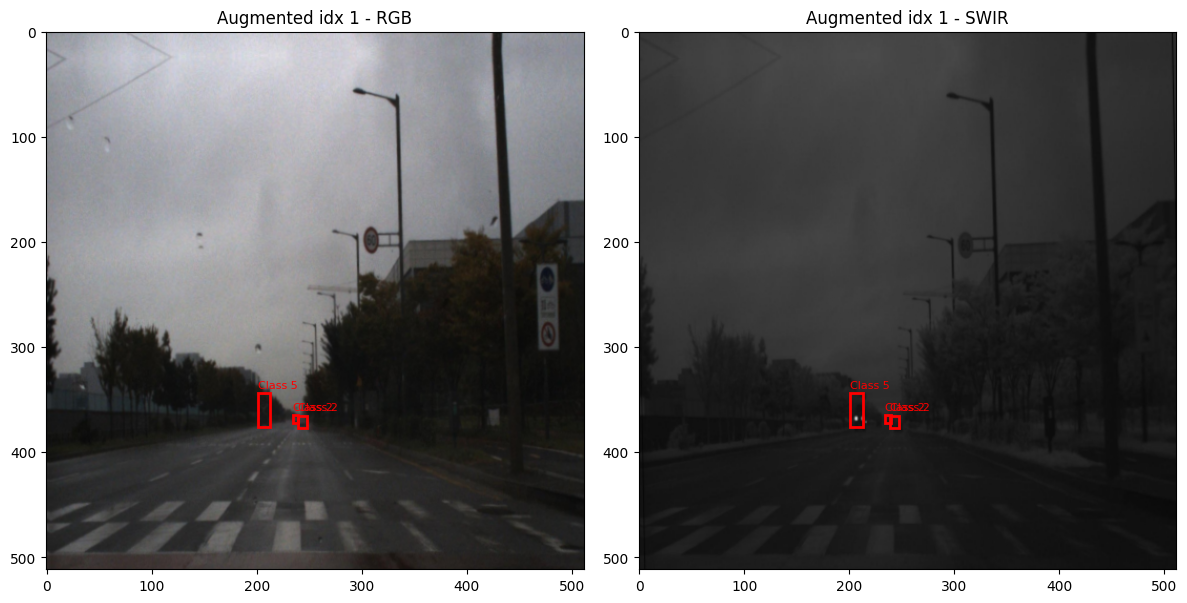

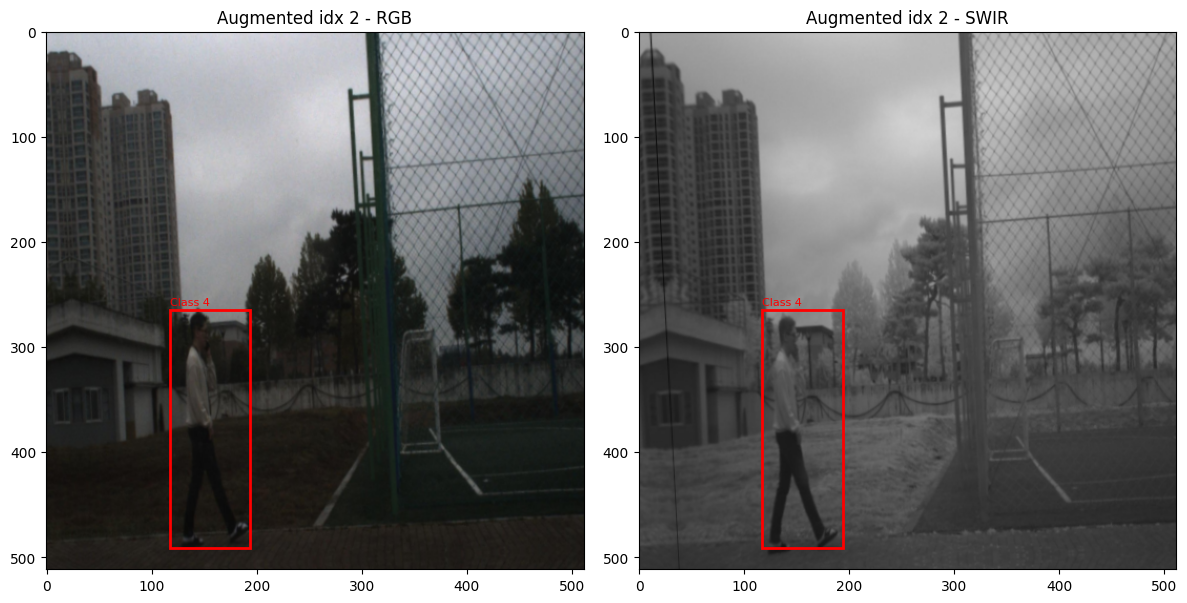

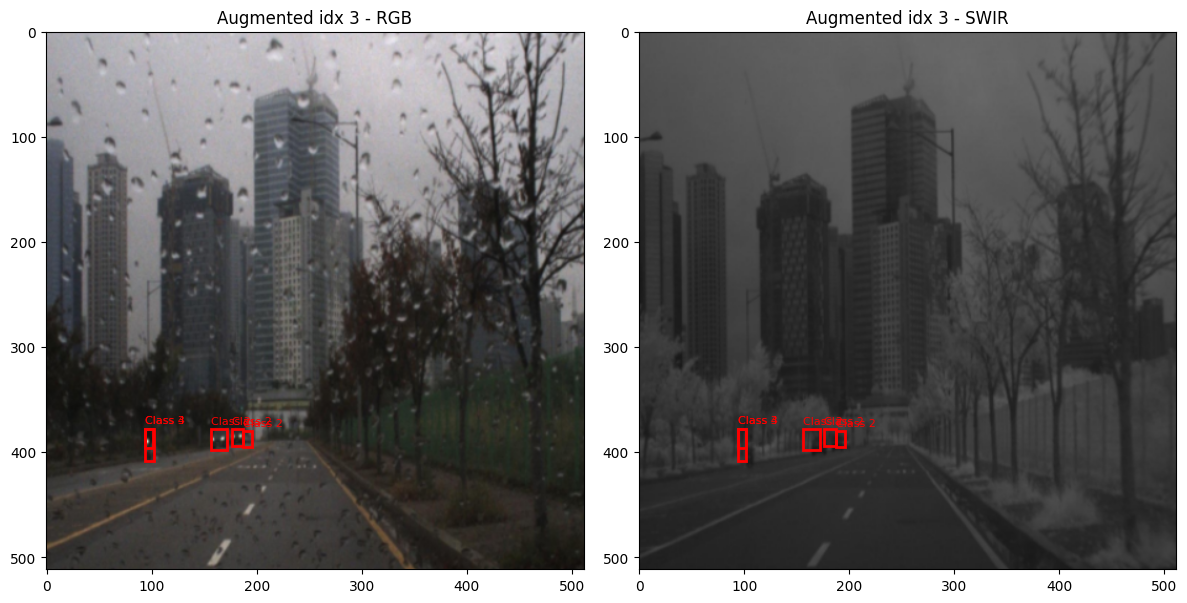

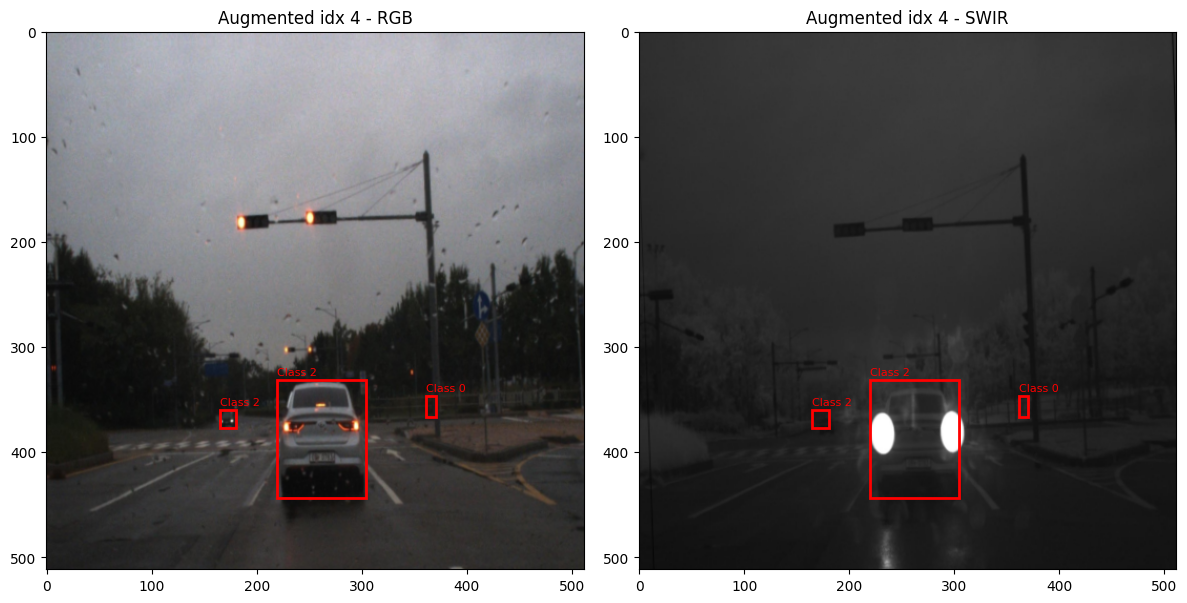

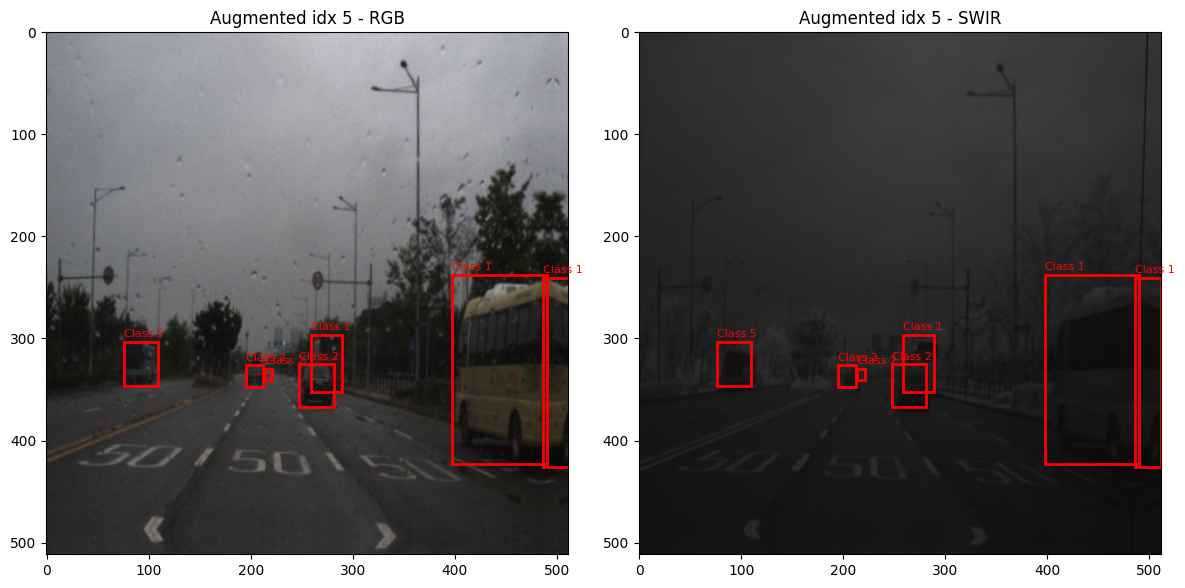

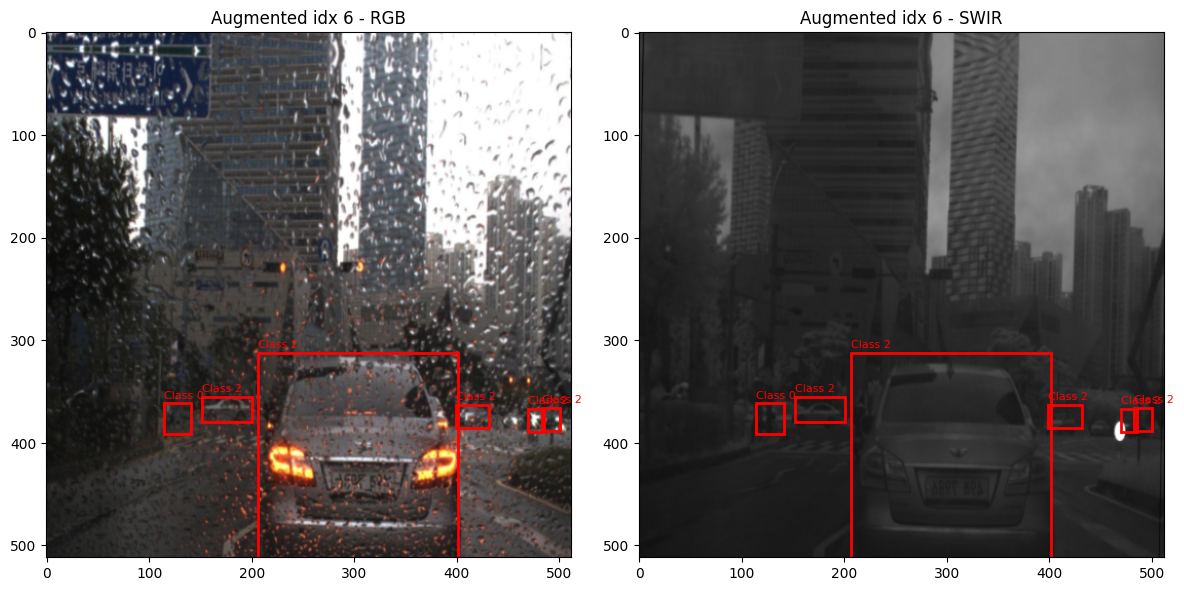

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import numpy as np

# 1) Print the albumentations pipeline
print("Albumentations pipeline:\n", balanced_dataset.geom)

# 2) Collect only augmented indices (exclude 'original')
aug_idxs = [i for i, rec in enumerate(balanced_dataset.samples) if rec[0] != 'original']
print(f"Found {len(aug_idxs)} augmented entries.")

# 3) Randomness check on one augmented item
test_idx = aug_idxs[0] if aug_idxs else 0
s1, _ = balanced_dataset[test_idx]
s2, _ = balanced_dataset[test_idx]
print("same twice?", torch.allclose(s1["rgb"], s2["rgb"]))

# 4) Visualize a few augmented samples with your helper
to_show = aug_idxs[:6] if aug_idxs else list(range(6))
for i in to_show:
    samples, target = balanced_dataset[i]

    # Ensure boxes/labels are numpy for your helper (prevents matplotlib dtype issues)
    boxes  = target["boxes"].detach().cpu().numpy() if torch.is_tensor(target["boxes"]) else np.asarray(target["boxes"])
    labels = target["labels"].detach().cpu().numpy() if torch.is_tensor(target["labels"]) else np.asarray(target["labels"])

    visualize_sample(
        samples["rgb"], samples["swir"],
        boxes, labels,
        title=f"Augmented idx {i}"
    )
